In [227]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/data')

from get_users_info import *
from get_brand_category_info import *
from get_preference_matrix import *
from get_popular_items import *
import implicit
import faiss
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import precision_score
from itertools import islice
from pymongo import MongoClient
import certifi

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
# матрица предпочтений
pref_matrix = get_pref_matrix(to_csv=False)
item_user = pref_matrix.drop(columns=['id_s','id_list','item_total'], index = ['user_total'])

In [ ]:
users_info = get_users_info(to_csv=False)

In [4]:
def count_active_users(item_user = item_user, users_info = users_info, thresholds = 50):
    'считает число пользователей с заданным числом активностей по просмотрам, корзинам, вишлистам'
    users = []
    for threshold in range(thresholds):
        users_info_cut = users_info.loc[(users_info.products_quan + 
                                         users_info.carts_quan + 
                                         users_info.wish_quan) > threshold]

        user_item = item_user.T
        user_item_cut = user_item.loc[user_item.index.isin(users_info_cut.index)]

        users.append(user_item_cut.shape[0])

    return pd.DataFrame(users)

NameError: name 'users_info' is not defined

In [33]:
count_active_users(thresholds=20)
## можно еще посчитать среднее время, за которое пользователь доходит до каждого порога

,0
0,35789
1,18887
2,7993
3,5636
4,4285
5,3451
6,2833
7,2395
8,2061
9,1799


In [6]:
threshold = 3
def cut_user_item(item_user, threshold = 3):
    "оставляет только людей, которые посмотрели больше threshold категорий, можно улучшить и поставить относительно суммы по чуваку"
    user_item = item_user.T
    user_item_bin = (user_item > 0).astype(int)
    user_item_bin = user_item_bin.loc[user_item_bin.sum(axis = 1)>threshold]

    user_item_cut = user_item.loc[user_item.index.isin(user_item_bin.index)]
    item_user_cut = user_item_cut.T

    return user_item_cut

In [23]:
user_item_cut = cut_user_item(item_user)

In [8]:
# нормализуем строки матрицы юзер-айтем
user_item_cut_normalized = user_item_cut.div(user_item_cut.sum(axis = 1), axis = 0)

In [144]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [207]:
def recommend_NN(user_item_cut, user_item_cut_index, metric = 'euclid', k = 10, method ='faiss'):
    'берет на вход датафрейм с накликавшими пользователями (cf-able), каждому из них ищет k соседей\
     на основе metric и выдает рекомендации, user_..index определяет пользователей для генерации рекомендаций'
        # создаю индекс длиной числа брендов-категорий
        # добавляю туда все вектора по юзерам
    user_item_cut_normalized = user_item_cut.div(user_item_cut.sum(axis = 1), axis = 0)
    if len(user_item_cut_index) < user_item_cut.shape[0]:

        user_item_train = user_item_cut.loc[~user_item_cut.index.isin(user_item_cut_index)]
        user_item_test = user_item_cut.loc[user_item_cut.index.isin(user_item_cut_index)]
        user_item_train_norm = user_item_cut_normalized.loc[~user_item_cut_normalized.index.isin(user_item_cut_index)]
        user_item_test_norm = user_item_cut_normalized.loc[user_item_cut_normalized.index.isin(user_item_cut_index)]

    else:
        user_item_train = user_item_cut
        user_item_test = user_item_cut
        user_item_train_norm = user_item_cut_normalized
        user_item_test_norm = user_item_cut_normalized

    
    if method == 'faiss':
        
        if metric == 'euclid':
            index = faiss.IndexFlatL2(user_item_cut.shape[1],)
            
            user_item_array = np.array(user_item_train).astype('float32')
            user_item_array_test = np.array(user_item_test).astype('float32')
            
            if str(user_item_array.flags)[17:22] == 'False':
                user_item_array = user_item_array.copy(order='C')
                user_item_array_test = user_item_array_test.copy(order = 'C')
            index.add(user_item_array)
        elif metric == 'cosine':
            index = faiss.IndexFlatIP(user_item_cut.shape[1],)
            user_item_array = np.array(user_item_train_norm).astype('float32')
            user_item_array_test = np.array(user_item_test_norm).astype('float32')
            
            if str(user_item_array.flags)[17:22] == 'False':
                user_item_array = user_item_array.copy(order='C')
                user_item_array_test = user_item_array_test.copy(order = 'C')
            index.add(user_item_array)


        user_dict = {}
        # создаю юзера, для которого будут искаться соседи
        for searched_user_clid in user_item_cut_index:
            searched_user_index = user_item_test.index.get_loc(searched_user_clid)
            
            searched_user = user_item_array_test[searched_user_index]
            # меняю формат вектора, чтобы подходил для метода поиска
            searched_user = searched_user.reshape((1,searched_user.shape[0]))
            # нахожу k соседей для выбранного юзера
            dist, ind = index.search(searched_user, k = k)
            # оставляю только соседей
            ind_reshape = ind.reshape((k,))
    #         ind_reshape = ind_reshape[ind_reshape != searched_user_index]

            # нахожу соседей в юзер-айтем матрице, оставляю только столбы с ненулевыми элементами
            found_neighbours = user_item_cut.iloc[ind_reshape,:]
#             if metric == 'cosine':
            found_neighbours.loc[searched_user_clid] = user_item_cut.loc[searched_user_clid]

            found_neighbours.loc['preferred_bin'] = (found_neighbours.loc[searched_user_clid]>0).astype(int)
            found_neighbours.loc['preferred_exact'] = found_neighbours.loc[searched_user_clid]
            found_neighbours.loc['recommended_bin'] = (found_neighbours.mean(axis = 0)>0).astype(int)
            found_neighbours.drop(index = [searched_user_clid], inplace = True)
            found_neighbours.loc['recommended'] = found_neighbours.drop(index = ['recommended_bin',
                                                                                 'preferred_bin', 
                                                                                 'preferred_exact']).mean(axis = 0)

            # found_neighbours = found_neighbours.T
            # found_neighbours[found_neighbours.loc[:,'recommended_bin'] > 0].T
            user_dict[searched_user_clid] = {}
            user_dict[searched_user_clid]['neighbours'] = found_neighbours.iloc[:k,:]
            user_dict[searched_user_clid]['recommends'] = found_neighbours.loc['recommended']
            user_dict[searched_user_clid]['recommends_binary'] = found_neighbours.loc['recommended_bin']
            user_dict[searched_user_clid]['preferred_binary'] = found_neighbours.loc['preferred_bin']
            user_dict[searched_user_clid]['preferred_exact'] = found_neighbours.loc['preferred_exact']
            
    if method == 'hardcode':
        
        user_dict = {}
        for user_ in user_item_cut_index:
        # user_ = '1586517765142996502'
            user_prefs = user_item_cut.loc[user_]
            non_null_prefs = user_item_train.loc[:,user_prefs.loc[user_prefs!=0].index]
            nn = {}
            for user in non_null_prefs.index:
                if user != user_:
                    if metric == 'euclid':
                        distance = euclidean(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
                    if metric == 'cosine':
                        distance = cosine(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
                    nn[user] = distance

            found_neighbours = user_item_train.loc[take(k,{k: v for k, v in sorted(nn.items(), key=lambda item: item[1])})]
            recommends = found_neighbours.mean(axis = 0)
            user_dict[user_] = {}
            user_dict[user_]['recommends'] = recommends
            user_dict[user_]['preferred_binary'] = (user_item_cut.loc[user_]>0).astype(int)
            user_dict[user_]['preferred_exact'] = user_item_cut.loc[user_]
    return user_dict

In [206]:
user_dict['164244549698192856']['recommends']

(1017 ALYX 9SM, Футболки и лонгсливы)                      0.105263
(10sei0otto, Джемперы и свитеры)                           0.000000
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)          0.000000
(11 By Boris Bidjan Saberi, Штаны и брюки)                 0.052632
(424 On Fairfax, Куртки и пуховики)                        0.000000
(99%Is, Штаны и брюки)                                     0.000000
(A Cold Wall, Пальто и плащи)                              0.000000
(A Cold Wall, Футболки и лонгсливы)                        0.052632
(A Cold Wall, Штаны и брюки)                               0.000000
(A.P.C., Деним)                                            0.000000
(A1923, Ботинки и сапоги)                                  0.000000
(AMI, Пальто и плащи)                                      0.000000
(AMI, Рубашки)                                             0.105263
(AMI, Штаны и брюки)                                       0.000000
(Acne Studios, Деним)                           

In [189]:
user_item_cut.loc[searched_user_clid]

(1017 ALYX 9SM, Футболки и лонгсливы)                      5.0
(10sei0otto, Джемперы и свитеры)                           0.0
(11 By Boris Bidjan Saberi, Футболки и лонгсливы)          0.0
(11 By Boris Bidjan Saberi, Штаны и брюки)                 0.0
(424 On Fairfax, Куртки и пуховики)                        0.0
(99%Is, Штаны и брюки)                                     0.0
(A Cold Wall, Пальто и плащи)                              0.0
(A Cold Wall, Футболки и лонгсливы)                        0.0
(A Cold Wall, Штаны и брюки)                               0.0
(A.P.C., Деним)                                            0.0
(A1923, Ботинки и сапоги)                                  0.0
(AMI, Пальто и плащи)                                      0.0
(AMI, Рубашки)                                             0.0
(AMI, Штаны и брюки)                                       0.0
(Acne Studios, Деним)                                      0.0
(Acne Studios, Джемперы и свитеры)                     

In [188]:
found_neighbours

,"(1017 ALYX 9SM, Футболки и лонгсливы)","(10sei0otto, Джемперы и свитеры)","(11 By Boris Bidjan Saberi, Футболки и лонгсливы)","(11 By Boris Bidjan Saberi, Штаны и брюки)","(424 On Fairfax, Куртки и пуховики)","(99%Is, Штаны и брюки)","(A Cold Wall, Пальто и плащи)","(A Cold Wall, Футболки и лонгсливы)","(A Cold Wall, Штаны и брюки)","(A.P.C., Деним)","(A1923, Ботинки и сапоги)","(AMI, Пальто и плащи)","(AMI, Рубашки)","(AMI, Штаны и брюки)","(Acne Studios, Деним)","(Acne Studios, Джемперы и свитеры)","(Acne Studios, Свитшоты и худи)","(Acne Studios, Футболки и лонгсливы)","(Acne Studios, Штаны и брюки)","(Adam Kimmel, Пиджаки и жилеты)","(Adidas, Кроссовки и кеды)","(Adidas, Куртки и пуховики)","(Air Jordan, Кроссовки и кеды)","(Alanui, Джемперы и свитеры)","(Alanui, Куртки и пуховики)","(Alanui, Шарфы, платки, перчатки)","(Alanui, Штаны и брюки)","(Alexander Digenova , Джемперы и свитеры)","(Alexander Digenova , Рубашки)","(Alexander Digenova , Свитшоты и худи)","(Alexander McQueen, Джемперы и свитеры)","(Alexander McQueen, Кроссовки и кеды)","(Alexander McQueen, Куртки и пуховики)","(Alexander McQueen, Пальто и плащи)","(Alexander Wang, Свитшоты и худи)","(Alexander Wang, Футболки и лонгсливы)","(Allsaints, Футболки и лонгсливы)","(Ambush Design, Куртки и пуховики)","(Ambush Design, Сумки и кошельки)","(Amiri, Деним)","(Amiri, Кроссовки и кеды)","(Amiri, Куртки и пуховики)","(Amiri, Рубашки)","(Andrea Yaaqov, Куртки и пуховики)","(Andrea Yaaqov, Штаны и брюки)","(Andy Wolf, Очки)","(Ann Demeulemeester, Ботинки и сапоги)","(Ann Demeulemeester, Пиджаки и жилеты)","(Ann Demeulemeester, Рубашки)","(Ann Demeulemeester, Шарфы, платки, перчатки)","(Ann Demeulemeester, Штаны и брюки)","(Archvio J.M. Ribot, Пиджаки и жилеты)","(Archvio J.M. Ribot, Рубашки)","(Attachment, Куртки и пуховики)","(Attachment, Пиджаки и жилеты)","(Attachment, Футболки и лонгсливы)","(Attachment, Штаны и брюки)","(Automatic Vertical, Джемперы и свитеры)","(Azs Tokyo, Головные уборы)","(Backlash, Деним)","(Backlash, Кожаные куртки)","(Balenciaga, Ботинки и сапоги)","(Balenciaga, Деним)","(Balenciaga, Джемперы и свитеры)","(Balenciaga, Кроссовки и кеды)","(Balenciaga, Куртки и пуховики)","(Balenciaga, Пальто и плащи)","(Balenciaga, Пиджаки и жилеты)","(Balenciaga, Рубашки)","(Balenciaga, Свитшоты и худи)","(Balenciaga, Сумки и кошельки)","(Balenciaga, Футболки и лонгсливы)","(Balenciaga, Штаны и брюки)","(Balmain, Деним)","(Balmain, Кожаные куртки)","(Balmain, Куртки и пуховики)","(Balmain, Пиджаки и жилеты)","(Balmain, Свитшоты и худи)","(Balmain, Футболки и лонгсливы)","(Balmain, Шорты и плавки)","(Balmain, Штаны и брюки)","(Bape, Свитшоты и худи)","(Bape, Штаны и брюки)","(Bears Heal Tears, Украшения и другое)","(Ben Taverniti Unravel Project, Куртки и пуховики)","(Ben Taverniti Unravel Project, Футболки и лонгсливы)","(Ben Taverniti Unravel Project, Штаны и брюки)","(Billionaire Boys Club, Куртки и пуховики)","(Billionaire Boys Club, Свитшоты и худи)","(Boris Bidjan Saberi, Кожаные куртки)","(Boris Bidjan Saberi, Куртки и пуховики)","(Boris Bidjan Saberi, Рубашки)","(Boris Bidjan Saberi, Свитшоты и худи)","(Boris Bidjan Saberi, Туфли)","(Boris Bidjan Saberi, Футболки и лонгсливы)","(Boris Bidjan Saberi, Штаны и брюки)","(Borsalino, Головные уборы)","(Bottega Veneta, Ботинки и сапоги)","(Bottega Veneta, Джемперы и свитеры)","(Bottega Veneta, Кроссовки и кеды)","(Bottega Veneta, Ремни)","(Bottega Veneta, Сандалии и тапочки)","(Bottega Veneta, Туфли)","(Bottega Veneta, Украшения и другое)","(Bottega Veneta, Штаны и брюки)","(Brioni, Деним)","(Brioni, Джемперы и свитеры)","(Brioni, Пальто и плащи)","(Brioni, Ремни)","(Brunello Cucinelli, Куртки и пуховики)","(Brunello Cucinelli, Штаны и брюки)","(Burberry, Кожаные куртки)","(Burberry, Куртки и пуховики)","(Burberry, Пальто и плащи)","(Burberry, Пиджаки и жилеты)","(Burberry, Рубашки)","(Burberry, Шарфы, платки, перчатки)","(Burberry Prorsum, Пальто и плащи)","(Burberry Prorsum, Штаны и брюки)","(Buttero, Бо

In [147]:
# хардкодим поиск ближ соседей по заполненным колонкам
user_dict = {}
for user_ in tqdm(user_item_diff.index):
# user_ = '1586517765142996502'
    user_prefs = user_item_cut.loc[user_]
    non_null_prefs = user_item_cut.loc[:,user_prefs.loc[user_prefs!=0].index]
    nn = {}
    for user in non_null_prefs.index:
        if user != user_:
            if metric == 'euclid':
                distance = euclidean(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
            if metric == 'cosine':
                distance = cosine(user_prefs.loc[user_prefs!=0], non_null_prefs.loc[user])
            nn[user] = distance

    found_neighbours = user_item_cut.loc[take(10,{k: v for k, v in sorted(nn.items(), key=lambda item: item[1])})]
    recommends = found_neighbours.mean(axis = 0)
    user_dict[user_] = {}
    user_dict[user_]['recommends'] = recommends
    user_dict[user_]['preferred_binary'] = user_item_cut.loc[user_]

100%|█████████████████████████████████████████| 147/147 [01:02<00:00,  2.35it/s]


In [34]:
def get_old_user_item(user_item, days_back = 7, threshold = 3):
    "достает юзер-айтем на days_back дней назад и обрезает ее до заданного числа активностей, по сути это почти трейн"
    # подгружаем старую юзер-айтем
    item_user_old = get_pref_matrix(to_csv=False, days_back=days_back)

    user_item_old = item_user_old.T
    user_item_old = user_item_old.drop(index=['id_s','id_list','item_total'], columns = ['user_total'])
    
    # обрезаем неактивных чуваков
    user_item_old_cut = cut_user_item(item_user=user_item_old.T, threshold=threshold)
    
    # добавляем возможно новые появившиеся категории и заполняем нулями
    user_item_old_cut = user_item_old_cut.reindex(columns=user_item_cut.columns, fill_value=0)
    return user_item_old_cut

In [40]:
user_item_old_cut = get_old_user_item(user_item_cut, days_back=20)

In [46]:
users_with_new_prefs

175

In [48]:
def get_binarized_differences(user_item_cut, user_item_old_cut, do_first = 'binarize'):
    "трейн выборка для первой метрики: те, у кого разность между бинаризованными векторами предпочтений ненулевая \
    или бинаризованная разность ненулевая"
    assert do_first in ['binarize','subtract']
    user_item_diff = pd.DataFrame(columns=user_item_cut.columns)
    users_with_new_prefs = []
    for user in user_item_old_cut.index:
        #тут сначала бинаризовать а потом вычитать только!!!!!!!
        if do_first == 'binarize':
            new_prefs = (user_item_cut.loc[user]>0).astype(int) - (user_item_old_cut.loc[user]>0).astype(int)
        if do_first == 'subtract':
        # тут, логично, больше будет валидационная выборка
            new_prefs = ((user_item_cut.loc[user] - user_item_old_cut.loc[user])>0).astype(int)
        if new_prefs.sum() > 0:
            users_with_new_prefs.append(user)
            user_item_diff = user_item_diff.append(new_prefs)

    return user_item_diff

In [54]:
user_item_diff = get_binarized_differences(user_item_cut, user_item_old_cut, do_first='binarize')

In [55]:
user_item_diff.shape

(147, 584)

In [ ]:
# доделать эту метрику
# сделать доп метрику по расстоянию и тоже зафиттиться
# попробовать несколько раз наоценивать с шагом в неделю-две
# распихать все по функциям аккуратненько

### считаем метрики

In [56]:
def precision_at_k(user_item_diff:pd.DataFrame, 
                   user_item_cut:pd.DataFrame,
                   user_dict:dict, 
                   user:str, 
                   k = 15) -> float:
    "считает для каждого чела из валидационной части выборки метрику precision@k"
    target_bin = user_item_diff.loc[user]
    predict_exact = user_dict[user]['recommends']

    compared = pd.DataFrame([target_bin, 
                             user_item_cut.loc[user]
                             ,
                             user_dict[user]['preferred_binary'],
                             predict_exact], index = ['fut','pref_exact','prev','predict_exact']).T
    compared.loc[:,'target_exact_new'] = np.where(compared.prev == 0, compared.pref_exact, 0)
    compared.loc[:,'predict_exact_new'] = np.where(compared.prev == 0, compared.predict_exact, 0)

    y_true = compared.sort_values('target_exact_new',ascending = False).iloc[:k,:]['fut']
    y_pred = np.where(compared.sort_values('target_exact_new',ascending = False).iloc[:k,:]['predict_exact_new'] >0,1,0)
    acc = precision_score(y_true, y_pred)
    return acc

In [57]:
def recall_at_k(user_item_diff:pd.DataFrame, 
                user_dict:dict, 
                user:str, 
                k = 15) -> float:
    "считает для каждого чела из валидационной части выборки метрику recall@k"
    target_bin = user_item_diff.loc[user]
    predict_exact = user_dict[user]['recommends']

    compared = pd.DataFrame([target_bin, 
                             user_dict[user]['preferred_binary'],
                             predict_exact], index = ['fut','prev','predict_exact']).T
    compared.loc[:,'predict_exact_new'] = np.where(compared.prev == 0, compared.predict_exact, 0)

    y_true = compared.sort_values('predict_exact_new',ascending = False).iloc[:k,:]['fut']
    y_pred = np.where(compared.sort_values('predict_exact_new',ascending = False).iloc[:k,:]['predict_exact_new'] >0,1,0)
    acc = precision_score(y_true, y_pred)
    return acc

In [58]:
def get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k):
    "считает для таргет матрицы и столбцов предиктов метрику на выбор"
    
    user_acc = {}
    for user in user_item_diff.index:
        precision = precision_at_k(user_item_diff, user_item_cut, user_dict, user, k)
        recall = recall_at_k(user_item_diff, user_dict, user, k)
        user_acc[user] = {}
        user_acc[user]['precision'] = precision
        user_acc[user]['recall'] = recall
        
    mean_precision = np.mean([user_acc[user]['precision'] for user in user_acc])
    max_precision = max([user_acc[user]['precision'] for user in user_acc])
    
    mean_recall = np.mean([user_acc[user]['recall'] for user in user_acc])
    max_recall = max([user_acc[user]['recall'] for user in user_acc])    
    
    return mean_precision, max_precision, mean_recall, max_recall

In [458]:
def get_accuracy(user_item_diff, user_dict, metric = 'euclid'):
    "подсчитывает процент попаданий предсказанных айтемов в фактически новые просмотренные айтемы \
    user_item_diff - дф с новыми просмотрами людей, user_dict хранит рекомендации"
    user_acc = {}
    for user in user_item_diff.index:
        target_bin = user_item_diff.loc[user]
        target_exact = user_dict[user]['preferred_exact']
        predict_bin = user_dict[user]['recommends_binary'] 
        predict_exact = user_dict[user]['recommends']
        
        # попали, если число нулей в разности увеличилось
        compared = pd.DataFrame([predict_bin,
                                 target_bin, 
                                 user_dict[user]['preferred_binary'],
                                 target_exact, 
                                 predict_exact], index = ['predict','fut','prev','target_exact','predict_exact']).T
        compared.loc[:,'pred_only'] = (compared.predict - compared.prev).map(lambda x: 1 if x == 1 else 0)
        
        user_acc[user] = {}
        user_acc[user]['recommends'] = (predict_bin > 0).sum()
        acc = compared.loc[(compared.pred_only == 1) & 
                           (compared.fut == 1)].shape[0] / (compared.loc[compared.pred_only==1].shape[0] + 10**(-6))

        user_acc[user]['accuracy'] = acc
        if metric == 'euclid':
            dist_bin = euclidean(compared.pred_only, compared.fut)
            dist_exact = euclidean(compared.loc[compared.pred_only==1]['target_exact'],
                                   compared.loc[compared.pred_only==1]['predict_exact'])
        if metric == 'cosine':
            dist_bin = cosine(compared.pred_only, compared.fut) 
            dist_exact = cosine(compared.loc[compared.pred_only==1]['target_exact'],
                                compared.loc[compared.pred_only==1]['predict_exact'])
        user_acc[user]['distance_bin'] = dist_bin
        user_acc[user]['distance_exact'] = dist_exact


    mean_acc = np.mean([user_acc[user]['accuracy'] for user in user_acc])
    max_acc = max([user_acc[user]['accuracy'] for user in user_acc])
    mean_rec_quan = np.mean([user_acc[user]['recommends'] for user in user_acc])
    satisfied_users_perc = (pd.Series(user_acc).apply(pd.Series)['accuracy'] > 0).sum() / len(user_acc)
    sum_distance_bin = sum([user_acc[user]['distance_bin'] for user in user_acc])
    sum_distance_exact = sum([user_acc[user]['distance_exact'] for user in user_acc])
    
    return mean_acc, max_acc, mean_rec_quan, satisfied_users_perc, sum_distance_bin, sum_distance_exact

100%|███████████████████████████████████████████| 25/25 [13:23<00:00, 32.14s/it]


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

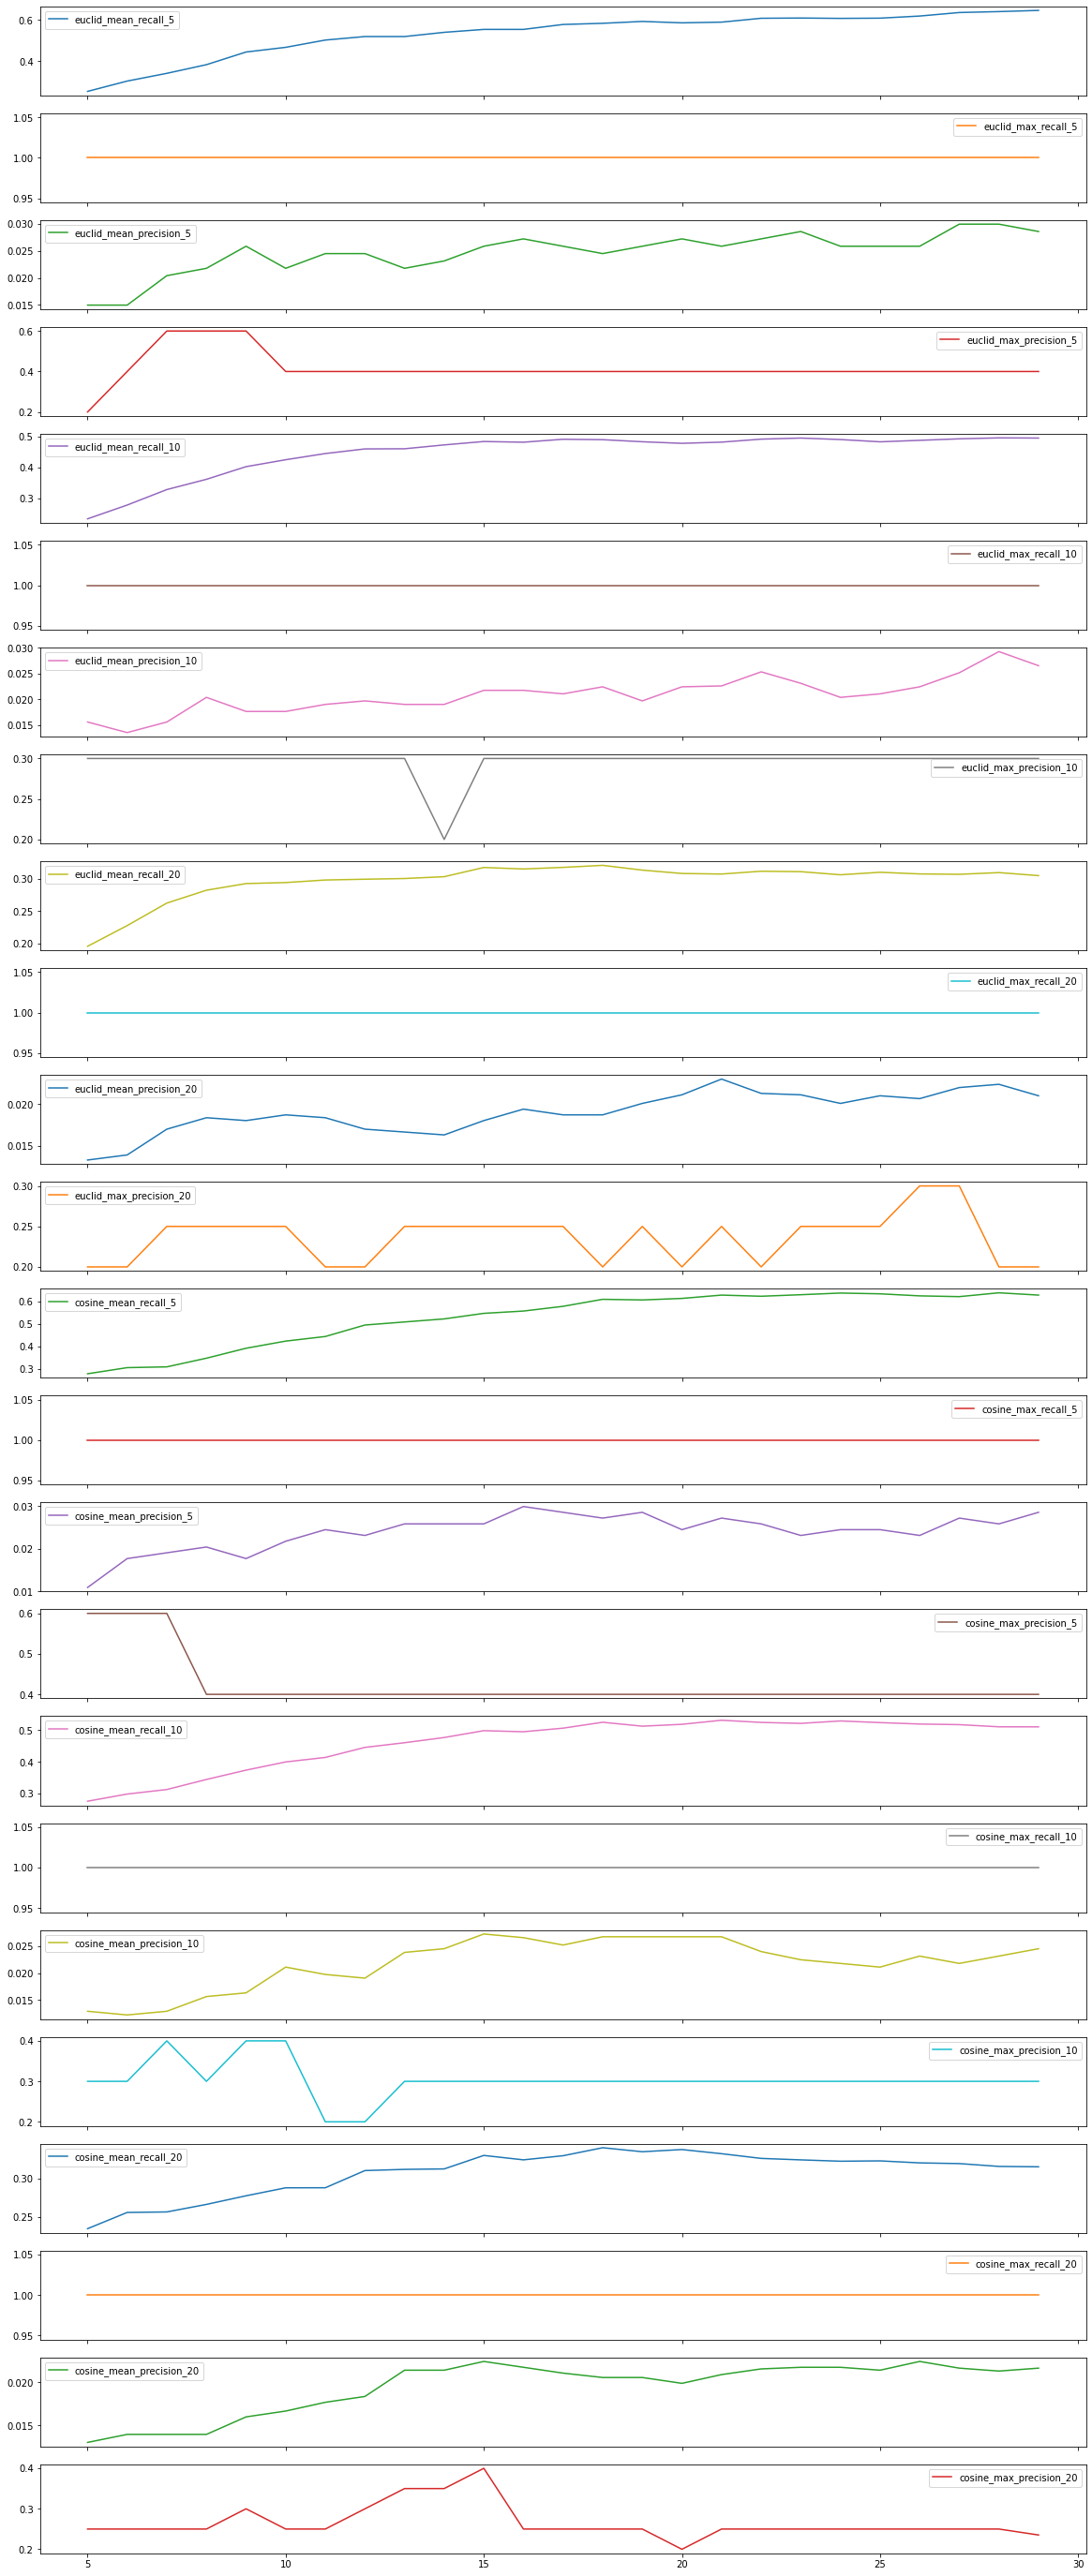

In [160]:
# теперь, варьируя разные параметры (в первую очередь число соседей и метрику), найдем где достигается максимум метрик
k_s = [5,10,20]
results_euclid = pd.DataFrame(columns = [i for sub in [(f'euclid_mean_{metrics}_{k_s[j]}', 
                                          f'euclid_max_{metrics}_{k_s[j]}') for j in range(len(k_s)) 
                                         for metrics in ['recall','precision']] for i in sub])
results_cosine = pd.DataFrame(columns = [i for sub in [(f'cosine_mean_{metrics}_{k_s[j]}', 
                                          f'cosine_max_{metrics}_{k_s[j]}') for j in range(len(k_s)) 
                                         for metrics in ['recall','precision']] for i in sub])
for metric in ['euclid', 'cosine']:
    for k in tqdm(range(5,30), leave = True):
        user_dict = recommend_NN(user_item_old_cut,user_item_diff.index, metric = metric, k = k)
        if metric == 'euclid':
            a = get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[0]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[1]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[2])
            
            results_euclid.loc[k] = [i for sub in a for i in sub]
        if metric == 'cosine':
            a = get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[0]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[1]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[2])
            
            results_cosine.loc[k] = [i for sub in a for i in sub]
results1 = results_euclid.join(results_cosine)
results1.plot(subplots = True, figsize = (20,50))

In [138]:
results1.columns = [i for sub in [(f'{dist}_mean_{metrics}_{k_s[j]}', 
                                          f'{dist}_max_{metrics}_{k_s[j]}') for dist in ['euclid','cosine'] for j in range(len(k_s)) 
                                         for metrics in ['recall','precision'] ] for i in sub]

In [62]:
results.iloc[:,[0,12]].join(results1.iloc[:,[0,12]], rsuffix ='_r').plot(), results.iloc[:,[2,14]].join(results1.iloc[:,[2,14]], rsuffix ='_r').plot()

NameError: name 'results' is not defined

(<AxesSubplot:xlabel='number of neighbours', ylabel='avg_recall'>,
 <AxesSubplot:xlabel='number of neighbours', ylabel='avg_precision'>)

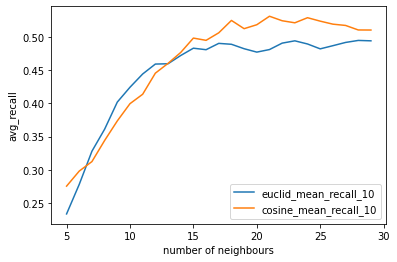

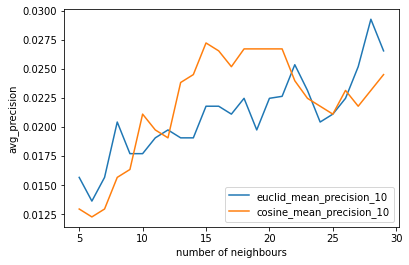

In [237]:
results1.iloc[:,[4,16]].plot(xlabel = 'number of neighbours', ylabel = 'avg_recall'), \
results1.iloc[:,[6,18]].plot(xlabel = 'number of neighbours', ylabel = 'avg_precision')

(<AxesSubplot:xlabel='number of neighbours', ylabel='avg_recall'>,
 <AxesSubplot:xlabel='number of neighbours', ylabel='avg_precision'>)

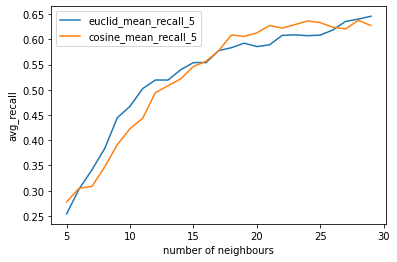

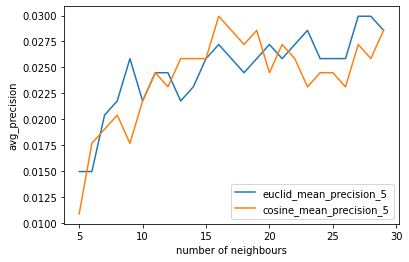

In [238]:
results1.iloc[:,[0,12]].plot(xlabel = 'number of neighbours', ylabel = 'avg_recall'), \
results1.iloc[:,[2,14]].plot(xlabel = 'number of neighbours', ylabel = 'avg_precision')

In [141]:
results1

,euclid_mean_recall_5,euclid_max_recall_5,euclid_mean_precision_5,euclid_max_precision_5,euclid_mean_recall_10,euclid_max_recall_10,euclid_mean_precision_10,euclid_max_precision_10,euclid_mean_recall_20,euclid_max_recall_20,euclid_mean_precision_20,euclid_max_precision_20,cosine_mean_recall_5,cosine_max_recall_5,cosine_mean_precision_5,cosine_max_precision_5,cosine_mean_recall_10,cosine_max_recall_10,cosine_mean_precision_10,cosine_max_precision_10,cosine_mean_recall_20,cosine_max_recall_20,cosine_mean_precision_20,cosine_max_precision_20
5,0.253968,1.0,0.014966,0.2,0.233673,1.0,0.015646,0.3,0.195465,1.0,0.013341,0.20,0.277778,1.0,0.010884,0.6,0.275510,1.0,0.012925,0.3,0.234921,1.0,0.013010,0.25
6,0.303855,1.0,0.014966,0.4,0.278199,1.0,0.013605,0.3,0.227647,1.0,0.013946,0.20,0.304989,1.0,0.017687,0.6,0.298186,1.0,0.012245,0.3,0.256009,1.0,0.013946,0.25
7,0.341270,1.0,0.020408,0.6,0.328086,1.0,0.015646,0.3,0.262632,1.0,0.017007,0.25,0.308390,1.0,0.019048,0.6,0.312472,1.0,0.012925,0.4,0.256689,1.0,0.013946,0.25
8,0.383220,1.0,0.021769,0.6,0.361224,1.0,0.020408,0.3,0.282621,1.0,0.018367,0.25,0.346939,1.0,0.020408,0.4,0.344218,1.0,0.015646,0.3,0.266472,1.0,0.013946,0.25
9,0.444444,1.0,0.025850,0.6,0.402041,1.0,0.017687,0.3,0.292962,1.0,0.018027,0.25,0.391156,1.0,0.017687,0.4,0.373696,1.0,0.016327,0.4,0.277681,1.0,0.015986,0.30
10,0.467120,1.0,0.021769,0.4,0.424376,1.0,0.017687,0.3,0.294534,1.0,0.018707,0.25,0.422902,1.0,0.021769,0.4,0.399660,1.0,0.021088,0.4,0.288055,1.0,0.016667,0.25
11,0.502268,1.0,0.024490,0.4,0.444331,1.0,0.019048,0.3,0.298502,1.0,0.018367,0.20,0.443311,1.0,0.024490,0.4,0.413832,1.0,0.019728,0.2,0.288111,1.0,0.017687,0.25
12,0.519274,1.0,0.024490,0.4,0.459297,1.0,0.019728,0.3,0.299717,1.0,0.017007,0.20,0.494331,1.0,0.023129,0.4,0.445578,1.0,0.019048,0.2,0.310447,1.0,0.018367,0.30
13,0.519274,1.0,0.021769,0.4,0.459751,1.0,0.019048,0.3,0.300799,1.0,0.016667,0.25,0.507937,1.0,0.025850,0.4,0.460317,1.0,0.023810,0.3,0.311986,1.0,0.021429,0.35
14,0.539683,1.0,0.023129,0.4,0.472184,1.0,0.019048,0.2,0.303636,1.0,0.016327,0.25,0.521542,1.0,0.025850,0.4,0.476757,1.0,0.024490,0.3,0.312593,1.0,0.021429,0.35


In [157]:
k_s = [5,10,20]
results_faiss = pd.DataFrame(columns = [i for sub in [(f'faiss_mean_{metrics}_{k_s[j]}', 
                                          f'faiss_max_{metrics}_{k_s[j]}') for j in range(len(k_s)) 
                                         for metrics in ['recall','precision']] for i in sub])
results_hardcode = pd.DataFrame(columns = [i for sub in [(f'hardcode_mean_{metrics}_{k_s[j]}', 
                                          f'hardcode_max_{metrics}_{k_s[j]}') for j in range(len(k_s)) 
                                         for metrics in ['recall','precision']] for i in sub])
metric = 'cosine'
for method in ['hardcode','faiss']:
    for k in tqdm([3,5,8,12,15,20,30,35], leave = True):
        user_dict = recommend_NN(user_item_old_cut,user_item_diff.index, metric = metric, k = k, method=method)
        if method == 'hardcode':
            a = get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[0]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[1]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[2])
            
            results_hardcode.loc[k] = [i for sub in a for i in sub]
        if method == 'faiss':
            a = get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[0]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[1]), \
                get_metrics_at_k(user_item_diff, user_item_cut, user_dict, k_s[2])
            
            results_faiss.loc[k] = [i for sub in a for i in sub]
results_2 = results_hardcode.join(results_faiss)

100%|█████████████████████████████████████████████| 8/8 [04:15<00:00, 31.96s/it]


(<AxesSubplot:xlabel='number of neighbours', ylabel='avg_recall'>,
 <AxesSubplot:xlabel='number of neighbours', ylabel='avg_precision'>,
 <AxesSubplot:xlabel='number of neighbours', ylabel='avg_recall'>,
 <AxesSubplot:xlabel='number of neighbours', ylabel='avg_precision'>)

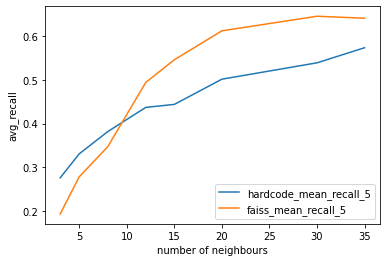

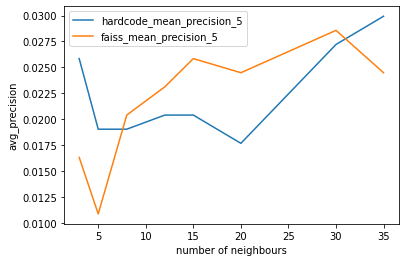

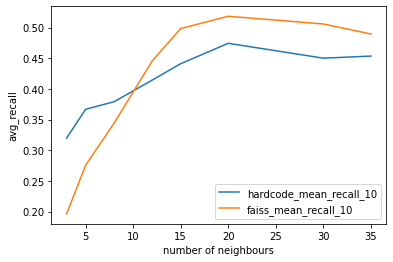

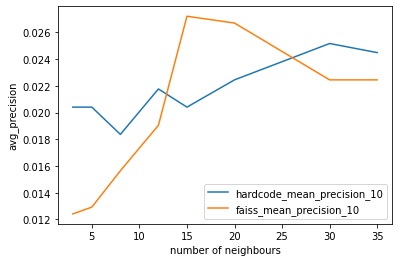

In [164]:
results_2.iloc[:,[0,12]].plot(xlabel = 'number of neighbours', ylabel = 'avg_recall'), \
results_2.iloc[:,[2,14]].plot(xlabel = 'number of neighbours', ylabel = 'avg_precision'), \
results_2.iloc[:,[4,16]].plot(xlabel = 'number of neighbours', ylabel = 'avg_recall'), \
results_2.iloc[:,[6,18]].plot(xlabel = 'number of neighbours', ylabel = 'avg_precision')

In [ ]:
# метрики: процент попавших из предложенных категорий по сравнению с добавившимися по факту на максимум
# и расстояние от вектора предложенных до фактических на минимум

In [ ]:
# написать цикл который бы создавал новый датафрейм с предсказанными значениями (каждому чуваку сопоставить строчку mean)
# если сравнивать не с тем же челом во времени, то относительно чего мерить точность?
# сравнивать будем с той же матрицей недельной давности по людям у которых вектора изменились чуть-чуть

### запихиваем полученные рекомендации в базу

In [80]:
id_dict = pref_matrix.id_list.drop(index='user_total').to_dict()

In [85]:
id_collection = []
for categ, id_list in id_dict.items():
    categ_dict = {}
    categ_dict['_id'] = categ
    categ_dict['items'] = id_list
    id_collection.append(categ_dict)
id_collection

[{'_id': ('1017 ALYX 9SM', 'Футболки и лонгсливы'),
  'items': ['2000000094304',
   '2000000106847',
   '2000000106991',
   '2000000129921']},
 {'_id': ('10sei0otto', 'Джемперы и свитеры'),
  'items': ['2000000015538', '2000000029931']},
 {'_id': ('11 By Boris Bidjan Saberi', 'Футболки и лонгсливы'),
  'items': ['2000000120348', '2000000120362', '2000000120379']},
 {'_id': ('11 By Boris Bidjan Saberi', 'Штаны и брюки'),
  'items': ['2000000053516', '2000000120058', '2000000120133']},
 {'_id': ('424 On Fairfax', 'Куртки и пуховики'),
  'items': ['2000000068664', '2000000121970', '2000000127620']},
 {'_id': ('99%Is', 'Штаны и брюки'),
  'items': ['2000000014616',
   '2000000026688',
   '2000000117287',
   '2000000117294']},
 {'_id': ('A Cold Wall', 'Пальто и плащи'),
  'items': ['2000000045955', '2000000089645']},
 {'_id': ('A Cold Wall', 'Футболки и лонгсливы'),
  'items': ['2000000084169', '2000000116815']},
 {'_id': ('A Cold Wall', 'Штаны и брюки'),
  'items': ['2000000128566', '20000

In [208]:
# делаем инференс для всех накликавших
user_dict_ = recommend_NN(user_item_cut=user_item_cut, user_item_cut_index=user_item_cut.index, k=20,method='faiss',metric = 'cosine')

In [223]:
def get_recommends_collection(user_dict, current_db, id_dict):
    "создает коллекцию монго формата из рекомендаций для каждого клида"
    recommends_collection = []
    for user in user_dict:
        user_recs = {}
        user_recs['_id'] = user
        recs_categ = user_dict[user]['recommends'].sort_values(ascending=False).head(5).index
        recs_id = [id_dict[categ] for categ in recs_categ]

        # собираем сортированный из чередующихся категорий
        recs_id_sorted = []
        max_len = max([len(l) for l in recs_id])
        for i in range(max_len):
            for list_ in recs_id:
                if i <= len(list_)-1:
                    recs_id_sorted.append(list_[i])

        user_recs['recommends'] = recs_id_sorted
        recommends_collection.append(user_recs)
    new_recs = list(get_popular_items(current_db))
    recommends_collection.append({'_id':'new','recommends': new_recs})
    return recommends_collection

In [224]:
recommends_collection = get_recommends_collection(user_dict_)

In [225]:
len(recommends_collection)

2714

In [117]:
path_to_repo = '/Users/kuznetsovnikita/recommendations' 
with open(path_to_repo+'/src/data/mongodb_pass.txt', 'r') as file:
    path2 = file.read()

In [119]:
client = MongoClient(path2,  tlsCAFile=certifi.where())
current_db = client['spin_services']

In [226]:
recommends_col_db = current_db['recommends']
recommends_col_db.delete_many({})
recommends_col_db.insert_many(recommends_collection)

In [234]:
', '.join(current_db['recommends'].find({'_id':'16023767312298152'})[0]['recommends'])

'2000000122229, 2000000015668, 2000000003573, 2000000059686, 2000000069272, 2000000122236, 2000000017952, 2000000059693, 2000000097077, 2000000078274, 2000000122243, 2000000018256, 2000000069265, 2000000104034, 2000000087351, 2000000122250, 2000000022048, 2000000071404, 2000000127910, 2000000087399, 2000000128924, 2000000022062, 2000000082608, 2000000111223, 2000000128931, 2000000023755, 2000000087498, 2000000114866, 2000000128955, 2000000027982, 2000000116266, 2000000128962, 2000000038742, 2000000119106, 2000000060767, 2000000128610, 2000000062112, 2000000130514, 2000000062174, 2000000095981, 2000000098005, 2000000102078, 2000000107752, 2000000114156, 2000000118680, 2000000118710, 2000000118918, 2000000123646, 2000000126555, 2000000129181, 2000000130354'

In [128]:
rec = ', '.join(current_db['recommends'].find({'_id':'16023767312298152'})[0]['recommends'])
rec

'2000000086309, 2000000126289, 2000000031866, 2000000031965, 2000000037004, 2000000037066, 2000000041384, 2000000062341, 2000000063836, 2000000063843, 2000000079660, 2000000084930, 2000000102733, 2000000104300, 2000000107226, 2000000110455, 2000000116785, 2000000118864, 2000000061771, 2000000066202, 2000000066219, 2000000066233, 2000000068244, 2000000084190, 2000000090894, 2000000093215, 2000000093246, 2000000093277, 2000000093284, 2000000093314, 2000000093345, 2000000093352, 2000000093444, 2000000097398, 2000000097435, 2000000099910, 2000000099941, 2000000099958, 2000000101835, 2000000101910, 2000000101958, 2000000101965, 2000000103754, 2000000111520, 2000000111896, 2000000111902, 2000000124117, 2000000126135, 2000000126593, 2000000126609, 2000000128306, 2000000128719, 2000000128733, 2000000128757, 2000000129839, 2000000129846, 2000000129853, 2000000079165, 2000000099378, 2000000099453, 2000000084121, 2000000106939, 2000000108292, 2000000114262, 2000000120171, 2000000121512, 200000012

## кусок с implicit модельками

In [184]:
csr_matrix(user_item_array)

<2410x576 sparse matrix of type '<class 'numpy.float32'>'
	with 22914 stored elements in Compressed Sparse Row format>

In [185]:
als_model = implicit.als.AlternatingLeastSquares(factors = 50)
als_model.fit(csr_matrix(user_item_array))

  0%|          | 0/15 [00:00<?, ?it/s]

In [210]:
sim_users = [i[0] for i in als_model.similar_users(0)]
sim_users

[0, 549, 412, 150, 393, 180, 205, 414, 517, 35]

## дальше ненужный кусок с корреляциями

In [24]:
item_corrs = np.corrcoef(item_user)

In [26]:
item_corrs_df = pd.DataFrame(item_corrs, index=item_user.index, columns=item_user.index)
item_corrs_df

,"(1017 ALYX 9SM, Футболки и лонгсливы)","(10sei0otto, Джемперы и свитеры)","(11 By Boris Bidjan Saberi, Футболки и лонгсливы)","(11 By Boris Bidjan Saberi, Штаны и брюки)","(424 On Fairfax, Куртки и пуховики)","(99%Is, Штаны и брюки)","(A Cold Wall, Пальто и плащи)","(A Cold Wall, Футболки и лонгсливы)","(A.P.C., Деним)","(A1923, Ботинки и сапоги)",...,"(Ys (Yamamoto), Пиджаки и жилеты)","(Ys (Yamamoto), Рубашки)","(Ys (Yamamoto), Футболки и лонгсливы)","(Ys (Yamamoto), Штаны и брюки)","(Yves Saint Laurent, Галстуки, запонки, носки)","(Yves Saint Laurent, Куртки и пуховики)","(Zegna Couture, Футболки и лонгсливы)","(Ziggy Chen, Штаны и брюки)","(kaval, Штаны и брюки)","(ВЛАД ВЫСОЦКИЙ, Украшения и другое)"
"(1017 ALYX 9SM, Футболки и лонгсливы)",1.000000,-0.000132,-0.000426,0.003863,-0.000208,-0.000465,0.017268,0.270277,0.011872,-0.000402,...,-0.000648,0.043212,-0.000365,-0.000497,-0.000412,-0.000825,-0.000132,-0.000535,-0.000339,0.005634
"(10sei0otto, Джемперы и свитеры)",-0.000132,1.000000,-0.000094,-0.000108,-0.000046,-0.000103,-0.000336,-0.000228,-0.000091,-0.000089,...,-0.000143,-0.000132,-0.000081,-0.000110,-0.000091,-0.000182,-0.000029,-0.000118,-0.000075,-0.000404
"(11 By Boris Bidjan Saberi, Футболки и лонгсливы)",-0.000426,-0.000094,1.000000,0.012087,0.102170,-0.000332,0.023961,-0.000737,-0.000296,-0.000287,...,0.009187,0.010002,-0.000261,0.009332,-0.000294,-0.000589,-0.000094,0.088735,-0.000242,0.020017
"(11 By Boris Bidjan Saberi, Штаны и брюки)",0.003863,-0.000108,0.012087,1.000000,-0.000171,0.014698,0.031908,0.036820,-0.000341,-0.000331,...,0.037301,-0.000493,0.026356,0.003044,-0.000339,0.051250,-0.000108,-0.000440,-0.000279,0.009894
"(424 On Fairfax, Куртки и пуховики)",-0.000208,-0.000046,0.102170,-0.000171,1.000000,-0.000162,0.009961,-0.000360,-0.000145,-0.000140,...,-0.000226,-0.000209,-0.000127,-0.000173,-0.000144,-0.000288,-0.000046,0.021589,-0.000118,-0.000639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Yves Saint Laurent, Куртки и пуховики)",-0.000825,-0.000182,-0.000589,0.051250,-0.000288,-0.000643,0.006612,0.016958,-0.000573,-0.000556,...,0.002461,-0.000828,-0.000505,0.019536,-0.000570,1.000000,-0.000182,-0.000740,-0.000468,0.019726
"(Zegna Couture, Футболки и лонгсливы)",-0.000132,-0.000029,-0.000094,-0.000108,-0.000046,-0.000103,-0.000336,-0.000228,-0.000091,-0.000089,...,-0.000143,-0.000132,-0.000081,-0.000110,-0.000091,-0.000182,1.000000,-0.000118,-0.000075,0.065505
"(Ziggy Chen, Штаны и брюки)",-0.000535,-0.000118,0.088735,-0.000440,0.021589,0.013090,0.003206,0.002823,-0.000371,-0.000361,...,0.128803,0.012781,-0.000327,-0.000445,-0.000370,-0.000740,-0.000118,1.000000,0.066099,0.000627
"(kaval, Штаны и брюки)",-0.000339,-0.000075,-0.000242,-0.000279,-0.000118,-0.000264,0.016201,0.020414,0.027661,-0.000228,...,0.333258,0.049395,-0.000207,0.022816,-0.000234,-0.000468,-0.000075,0.066099,1.000000,-0.001039


In [4]:
user_item = pref_matrix.drop(columns=['id_s','item_total'], index = ['user_total']).T
user_item

,"(1017 ALYX 9SM, Футболки и лонгсливы)","(10sei0otto, Джемперы и свитеры)","(11 By Boris Bidjan Saberi, Футболки и лонгсливы)","(11 By Boris Bidjan Saberi, Штаны и брюки)","(424 On Fairfax, Куртки и пуховики)","(99%Is, Штаны и брюки)","(A Cold Wall, Пальто и плащи)","(A Cold Wall, Футболки и лонгсливы)","(A.P.C., Деним)","(A1923, Ботинки и сапоги)",...,"(Ys (Yamamoto), Пиджаки и жилеты)","(Ys (Yamamoto), Рубашки)","(Ys (Yamamoto), Футболки и лонгсливы)","(Ys (Yamamoto), Штаны и брюки)","(Yves Saint Laurent, Галстуки, запонки, носки)","(Yves Saint Laurent, Куртки и пуховики)","(Zegna Couture, Футболки и лонгсливы)","(Ziggy Chen, Штаны и брюки)","(kaval, Штаны и брюки)","(ВЛАД ВЫСОЦКИЙ, Украшения и другое)"
1586517765142996502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586839436824718143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586861088574635654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586877094630823534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1587480513689496288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640668414990247385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1640817089200208316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642171750651415285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642196883929739524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
user1 = user_item.loc['1586517765142996502']
user2 = user_item.loc['1587480513689496288']
np.corrcoef(user1, user2)[0][1]

-0.005406218054745005

In [149]:
corrs

array([[ 1.        , -0.00884118, -0.00765223, ..., -0.00765223,
                nan,  0.02320118],
       [-0.00884118,  1.        , -0.00403977, ..., -0.00403977,
                nan, -0.01372663],
       [-0.00765223, -0.00403977,  1.        , ..., -0.0034965 ,
                nan, -0.01188068],
       ...,
       [-0.00765223, -0.00403977, -0.0034965 , ...,  1.        ,
                nan, -0.01188068],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.02320118, -0.01372663, -0.01188068, ..., -0.01188068,
                nan,  1.        ]])

In [15]:
corrs = np.corrcoef(user_item)


In [150]:
corrs_df = pd.DataFrame(corrs)

In [151]:
corrs_df

,0,1,2,3,4,5,6,7,8,9,...,34400,34401,34402,34403,34404,34405,34406,34407,34408,34409
0,1.000000,-0.008841,-0.007652,-0.008159,-0.005406,NaN,0.084935,0.054270,-0.016080,NaN,...,-0.005406,-0.005406,-0.005406,NaN,NaN,0.054270,-0.005406,-0.007652,NaN,0.023201
1,-0.008841,1.000000,-0.004040,-0.004307,-0.002854,NaN,-0.009070,-0.002854,-0.008489,NaN,...,-0.002854,-0.002854,-0.002854,NaN,NaN,-0.002854,-0.002854,-0.004040,NaN,-0.013727
2,-0.007652,-0.004040,1.000000,-0.003728,-0.002470,NaN,-0.007850,-0.002470,-0.007347,NaN,...,-0.002470,-0.002470,-0.002470,NaN,NaN,-0.002470,-0.002470,-0.003497,NaN,-0.011881
3,-0.008159,-0.004307,-0.003728,1.000000,-0.002634,NaN,0.213376,-0.002634,-0.007834,NaN,...,-0.002634,-0.002634,-0.002634,NaN,NaN,-0.002634,-0.002634,-0.003728,NaN,0.111984
4,-0.005406,-0.002854,-0.002470,-0.002634,1.000000,NaN,-0.005546,-0.001745,-0.005191,NaN,...,-0.001745,-0.001745,-0.001745,NaN,NaN,-0.001745,-0.001745,-0.002470,NaN,-0.008394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34405,0.054270,-0.002854,-0.002470,-0.002634,-0.001745,NaN,-0.005546,-0.001745,-0.005191,NaN,...,-0.001745,-0.001745,-0.001745,NaN,NaN,1.000000,-0.001745,-0.002470,NaN,-0.008394
34406,-0.005406,-0.002854,-0.002470,-0.002634,-0.001745,NaN,-0.005546,-0.001745,-0.005191,NaN,...,-0.001745,-0.001745,-0.001745,NaN,NaN,-0.001745,1.000000,-0.002470,NaN,-0.008394
34407,-0.007652,-0.004040,-0.003497,-0.003728,-0.002470,NaN,-0.007850,-0.002470,-0.007347,NaN,...,-0.002470,-0.002470,-0.002470,NaN,NaN,-0.002470,-0.002470,1.000000,NaN,-0.011881
34408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
corrs_df[1].isna().sum() == corrs_df.shape[0]

False

In [112]:
recommended = {}
for user in user_item.index:
    recommended[user] = {}

rec_items = 10
similar_users = 60
# среднее вместо сумм считать

for user in recommended:
    
    # тут отбираем для рек пользователя n похожих на него
    similar_users = corrs_df.loc[user].drop(user).nlargest(sim_users)

    # берем что смотрели похожие челы и складываем предпочтения
    similar_prefs = user_item.loc[similar_users.index]
    similar_prefs.loc['item_sum'] = similar_prefs.sum(axis = 0)

    # берем самые предпочтительные категории
    top_items = similar_prefs.T.sort_values('item_sum', ascending = False)
    
    # тут оставляю только те бренды-категории, в которых не отметился юзер, для которого рекомендуем
#     outer_recs = top_items.loc[
#         ~top_items.index.isin(item_user.loc[item_user[user] > 0].index)]['item_sum'].head(rec_items).to_dict()

    # тут оставляем, только при рекомендации конкретных штрихкодов, надо будет выкинуть те, где чел смотрел
    all_recs = top_items['item_sum'].head(rec_items).to_dict()
    
    recommended[user] = all_recs
#     break

In [113]:
recommended

{'1586517765142996502': {('Dolce & Gabbana', 'Куртки и пуховики'): 83.0,
  ('Stone Island', 'Свитшоты и худи'): 11.0,
  ('Giorgio Brato', 'Куртки и пуховики'): 1.0,
  ('Visvim', 'Свитшоты и худи'): 1.0,
  ('Ralph Lauren', 'Куртки и пуховики'): 1.0,
  ('Prada', 'Головные уборы'): 0.0,
  ('Paul Harnden Shoemakers', 'Пиджаки и жилеты'): 0.0,
  ('Paul Harnden Shoemakers', 'Рубашки'): 0.0,
  ('Pierre Balmain', 'Пальто и плащи'): 0.0,
  ('Pierre Balmain', 'Футболки и лонгсливы'): 0.0},
 '1586839436824718143': {('Archvio J.M. Ribot', 'Пиджаки и жилеты'): 69.0,
  ('Paul Harnden Shoemakers', 'Пиджаки и жилеты'): 66.0,
  ('Greg Lauren', 'Штаны и брюки'): 4.0,
  ('Paul Harnden Shoemakers', 'Рубашки'): 3.0,
  ('Saint Laurent Paris', 'Ремни'): 3.0,
  ('Maison Margiela', 'Пиджаки и жилеты'): 2.0,
  ('Boris Bidjan Saberi', 'Туфли'): 2.0,
  ('Vivienne Westwood', 'Пиджаки и жилеты'): 2.0,
  ('Carol Christian Poell', 'Рубашки'): 2.0,
  ('Isaac Sellam Experience', 'Кожаные куртки'): 2.0},
 '1586861088574

In [123]:
# проверяю заполненность предложенных
filling_by_user = {}

for user, recs in recommended.items():
    filling_by_user[user] = 0
    for rec, value in recs.items():
        if value > 0:
            filling_by_user[user] += 1/len(recs)
    filling_by_user[user] = round(filling_by_user[user],1)

<AxesSubplot:ylabel='Frequency'>

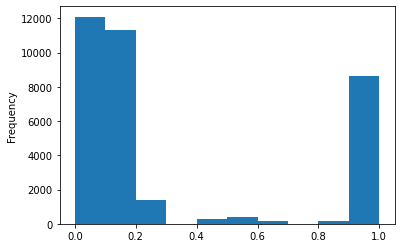

In [145]:
# распределение процентов заполненности
pd.Series(filling_by_user).plot(kind = 'hist', bins = 10)

In [164]:
# сколько людей с абсолютно никакими сходствами
null_rows = 0
for row in corrs_df:
    if corrs_df[row].isna().sum() == corrs_df.shape[0]:
        null_rows += 1
null_rows

12094

In [ ]:
# выкинуть всех пустых чуваков (или меньше какого-то колва оценок (параметром))
# пробовать косинусную кор-ю
# либо смотреть чтобы похожесть считалась (модуль implicit и др), по безнулевым элементам юзеров
# если нету то закодить 
# параметры: сколько похожих людей и какую степень похожести брать и их варьируем для оптимальности (возможно гибкие)
# делим выборку клиентов на трейн (тут подбор параметров выше) тест
# или разделить по времени людей на подвыборки (в пн идет в трейн, в вт в тест)

# по таргетам смотреть конверсии/увеличения по просмотрам


In [ ]:
# попробовать захардкодить поиск соседей без нулей
# причесать в срц
# зафиксить метрики (пресижн эт 5/10/30 зависит от того сколько показываем товаров чтобы не менялся знаменатель)
# запихнуть всех людей в валидацию, только сменит абс значения метрики
# подвигать окна
# пакет flask


In [ ]:
# для челов из валидации искать соседей только из трейна!!!
# закодил recall at k (сколько таргетов есть в предсказаниях)
# надо переделать чтобы искало сколько из предсказанных есть в таргете
# закодить их отдельными функциями для отдельных чуваков
# пересмотр графиков
# через фласк законнектить нулевую модельку (рандомайзер) 
# возможно про докер надо почитать на будущее

In [ ]:
# первое - закодить пресижн отдельно и реколл отдельно и функцию для пайплайна оценки с ними
# второе - сделать поиск соседей для валидируемых людей только в трейн выборке - обрезать матрицу
# третье - поднять коллекцию в монго: ключи - клаент айди, значения - список штрихкодов

In [ ]:
## комменты по презентации
# пинатть марата! 
#